#Model definition

In [ ]:
import numpy as np
import torch
import torch.nn as nn

In [ ]:
!git clone https://github.com/PepeCamposGarcia/PINNs.git

We are aiming to find a stationary solution to the two dimensional Navier-Stokes equations:
$$
\begin{cases}
    \rho \left( u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) = -\frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right),\\
    \rho \left(  u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) = -\frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right),\\
    \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0,
\end{cases}
$$
We are considering constant boundary conditions in a square-like cavity, given by the no-slip condition, considering inmobile walls at the bottom, left and right of the cavity. The top lid is in constant movement, inducing a stationary flow which this model tries to reconstruct.



In [ ]:
class SinusoidalActivation(nn.Module):
  def forward(self,x):
    return torch.sin(2 * np.pi * x)

In [ ]:

class NavierStokesModel(nn.Module):

############################### NET ARCHITECTURE ###############################

  def __init__(self, num_neurons, num_layers, nu, rho):
    self.nu = nu
    self.rho = rho

    super(NavierStokesModel, self).__init__()
    self.num_neurons = num_neurons
    self.num_layers = num_layers

### Imput layer, fully connected to the first hidden layer, sinusoidal activation
### function for the dismiss of local minima

    layer_list = [nn.Linear(2, self.num_neurons)]
    layer_list.append(SinusoidalActivation())

### Loop for the description of the hidden layers, fully connected layers
### hiperbolic tangent activation function

    for _ in range (self.num_layers - 2):
      layer_list.append(nn.Linear(self.num_neurons, self.num_neurons))
      layer_list.append(nn.Tanh())

### Output layer, 3 outputs (u,v,p)

    layer_list.append(nn.Linear(self.num_neurons, 3))
    self.layers = nn.ModuleList(layer_list)


################## FEED-FORWARD PROPAGATION, OUTPUTS ###########################

  def forward(self, x, y):
     """
        Params:
        x - array of shape (N, 1), input x coordinates
        y - array of shape (N, 1), input y coordinates
        Returns:
        u - tensor of shape (N, 1), output x-velocity
        v - tensor of shape (N, 1), output y-velocity
        p - tensor of shape (N, 1), output pressure
        f - x-momentum PDE evaluation of shape (N, 1)
        g - y-momentum PDE evaluation of shape (N, 1)
        h - continuity PDE evaluation of shape (N, 1)

     """
     x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
     y = torch.tensor(y, dtype=torch.float32, requires_grad=True)

     input_data = torch.hstack([x, y])

     out = input_data

     for layer in self.layers:
      out = layer(out)

     u, v, p = out[:, [0]], out[:, [1]], out[:, [2]] # (N, 1) each

     u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
     u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
     u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

     v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
     v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
     v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
     v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

     p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
     p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # Evaluate PDE's

     f = u * u_x + v * u_y + (1 / self.rho) * p_x - self.nu * (u_xx + u_yy) # (N, 1)
     g = u * v_x + v * v_y + (1 / self.rho) * p_y - self.nu * (v_xx + v_yy) # (N, 1)
     h = u_x + v_y

     return u, v, p, f, g, h


#Loss function

In [ ]:
class NavierStokesLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()

  def forward(self, u_BC, u_net_BC, v_net_BC, f, g, h):

     L_boundary = self.mse(u_net_BC, u_BC) + self.mse(v_net_BC, torch.zeros_like(v_net_BC))
     L_pde  = self.mse(f, torch.zeros_like(f)) + self.mse(g, torch.zeros_like(g)) + self.mse(h, torch.zeros_like(h))

     return 5*L_boundary + 2*L_pde

#Data loading

In [ ]:
import scipy
from tqdm import tqdm

In [ ]:
def boundary_indices(Ny, Nx):
    """
    Returns a boolean mask marking the boundary condition for all timesteps
    Params:
    Nx - # of x-axis spatial coordinates in domain
    Ny - # of y-axis spatial coordinates in domain
    Return:
    nd-array of shape (Nx*Ny, )
    """
    # Create grid for one timestep
    # Data is a 150 x 150 matrix
    # This function creates a boolean mask to identify every point in the boundary
    # of the spatial domain

    grid = np.zeros((150, 150))

    # Set boundary to 1

    grid[:, 0] = 1
    grid[0, :] = 1
    grid[:, -1] = 1
    grid[-1, :] = 1

    grid_in = grid.flatten().reshape(-1,1)

    # Flatten final grid into column vector to be used in training
    boundary_positions = grid_in.astype(bool)

    return boundary_positions

In [ ]:
import csv

In [ ]:
def data_loading () :

  x=torch.linspace(0,1,150)
  y=torch.linspace(0,1,150)
  Nx, Ny = x.shape[0], y.shape[0]
  XX,YY = torch.meshgrid(x,y)
  XX = XX.transpose(1,0)
  YY = YY.transpose(1,0)

  x_in = XX.flatten().reshape(-1, 1)  # NxNy x 1
  y_in = YY.flatten().reshape(-1, 1)  # NxNy x 1
  return x, y, x_in, XX, y_in, YY, (Ny, Nx)

#Training set construction

In [ ]:
x, y, x_in, XX, y_in, YY, (Ny, Nx) = data_loading ()
# It is in the variable 'idx_b_train' where we choose how many of
# the total boundary points will be used in training, in this case 500

# Boundary training points
idx_b = boundary_indices(Ny, Nx)
x_boundary = x_in[idx_b, :]
y_boundary = y_in[idx_b, :]
idx_b_train = np.random.choice(x_boundary.shape[0], 500, replace=False)
x_b_train = x_boundary[idx_b_train].reshape(-1,1)
y_b_train = y_boundary[idx_b_train].reshape(-1,1)

# Solution on each training point given by the b. conditions
indices_uno = np.where(y_b_train == 1)[0]
u_BC = np.zeros_like(y_b_train)
u_BC[indices_uno] = 1
u_BC = torch.tensor(u_BC, dtype = torch.float32).reshape(-1,1)
v_BC = torch.zeros_like(u_BC)

# Collocation
# In the variable 'samples', we define the fraction of the points used in training as collocation
samples = int(round(Nx * Ny * 0.40))

idx = np.random.choice(x_in.shape[0], samples, replace=False)
x_train = x_in[idx, :]
y_train = y_in[idx, :]

#Training algorithm

In [ ]:
from tqdm import tqdm

In [ ]:
def main(num_neurons, num_layers, epochs):
    """
    Params:
    num_neurons - int, # of hidden units for each neural network layer
    num_layers - int, # of neural network layers
    epochs - int, # of training epochs

    """
    nu = 0.01
    rho = 1

    PINN_model = NavierStokesModel(num_neurons=num_neurons, num_layers=num_layers, nu=nu, rho=rho)
    criterion = NavierStokesLoss()

    optimizer = torch.optim.LBFGS(PINN_model.parameters(), line_search_fn='strong_wolfe')

    def closure():
        """Define closure function to use with LBFGS optimizer"""
        optimizer.zero_grad()   # Clear gradients from previous iteration

        u_net, v_net, p_net, f, g, h = PINN_model(x_train, y_train)
        u_net_BC, v_net_BC, p_net_BC, fb, gb, hb = PINN_model(x_b_train, y_b_train)

        loss = criterion(u_BC, u_net_BC, v_net_BC, f, g, h)

        loss.backward() # Backprogation
        return loss

    def training_loop(epochs):
        """Run training loop"""

        for i in tqdm(range(epochs), desc='Training epochs: '):

          optimizer.step(closure)
          loss = closure().item()

    training_loop(epochs=epochs)
    torch.save(PINN_model.state_dict(), 'model_name.pth')
    return

Running the following cell will start the network training, and generate a .pth file named 'model_name.pth', with the width and depth specified in 'num_neurons' and 'num_layers', and trained over 'epochs' iterations. The training set used was constructed in the previous section.

In [ ]:
if __name__ == '__main__':
    main(num_neurons=num_neurons, num_layers=num_layers, epochs=epochs)

#Result representation functions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap='jet')
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap='jet')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()


def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap='jet')
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap='jet')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()

#Model loading
In the following section we consider two cases differing in the Reynolds number, Re=10 and Re=100. This number alludes to the turbulence of the flow, which increases with it.

In [ ]:
def load_saved_model10(num_layers, num_neurons):

    nu = 0.1
    rho = 1

    # load saved state_dict
    PINN_model = NavierStokesModel(num_neurons=num_neurons, num_layers=num_layers, nu=nu, rho=rho)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/CAVITY_NS/Models/NSCavityRe10.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
def load_saved_model100(num_layers, num_neurons):

    nu = 0.01
    rho = 1

    # load saved state_dict
    PINN_model = NavierStokesModel(num_neurons=num_neurons, num_layers=num_layers, nu=nu, rho=rho)
    PINN_model.load_state_dict(torch.load('/content/PINNs/Models_Data_Figures/CAVITY_NS/Models/NSCavityRe100.pth'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [ ]:
model10 = load_saved_model10(num_layers = 7, num_neurons = 30)
model100 = load_saved_model100(num_layers = 7, num_neurons = 30)

#Model evaluation

In [ ]:
# u_in_N, x-velocity field prediction
# v_in_N, y-velocity field prediction
# p_in_N, pressure field prediction
# fN, x-momentum PDE evaluation
# gN, y-momentum PDE evaluation
# hN, continuity PDE evaluation
# N, Reynolds number

# Re=10
u_in_10, v_in_10, p_in_10, f3, g3, h3 = model10(x_in, y_in)
UU10 = u_in_10.reshape(Ny, Nx).detach().transpose(1,0)
VV10 = v_in_10.reshape(Ny, Nx).detach().transpose(1,0)
PP10 = p_in_10.reshape(Ny, Nx).detach().transpose(1,0)

# Re=100
u_in_100, v_in_100, p_in_100, f1, g2, h2 = model100(x_in, y_in)
UU100 = u_in_100.reshape(Ny, Nx).detach().transpose(1,0)
VV100 = v_in_100.reshape(Ny, Nx).detach().transpose(1,0)
PP100 = p_in_100.reshape(Ny, Nx).detach().transpose(1,0)

#Contour plots
Re = 10

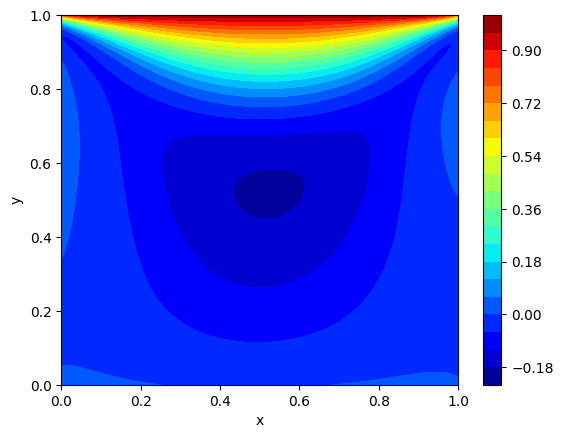

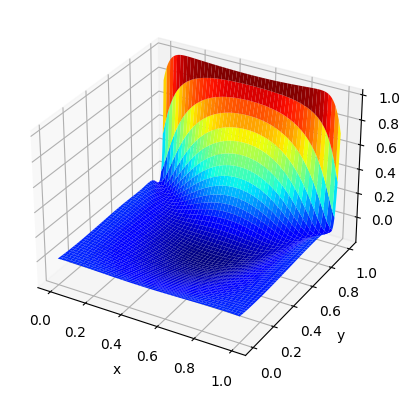

In [ ]:
# Horizontal flow velocity
plot3D_Matrix(XX,YY,UU10)

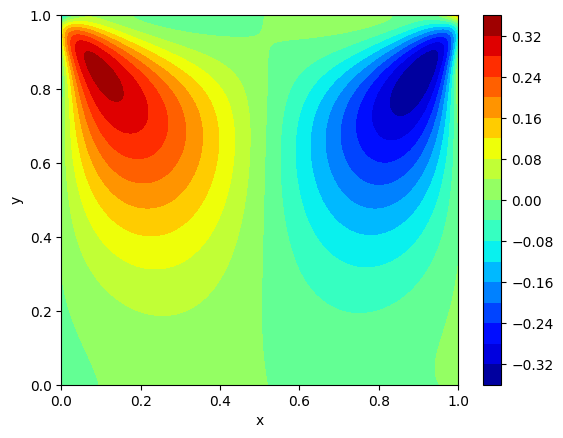

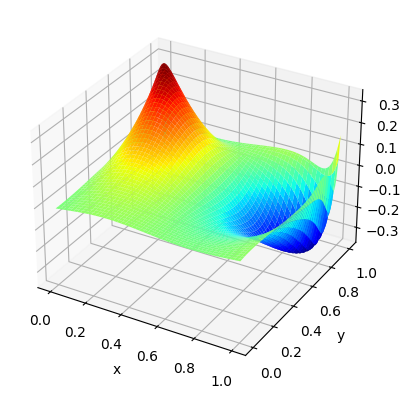

In [ ]:
# Vertical flow velocity
plot3D_Matrix(XX,YY,VV10)

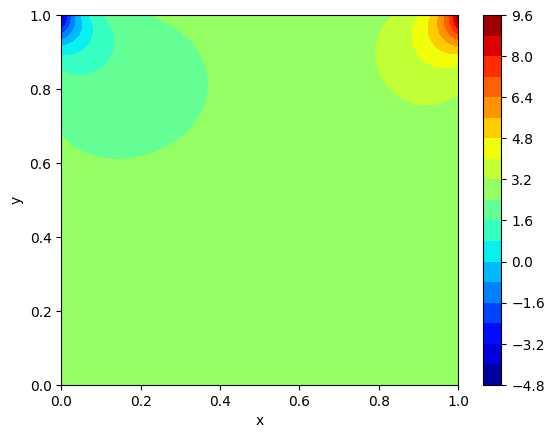

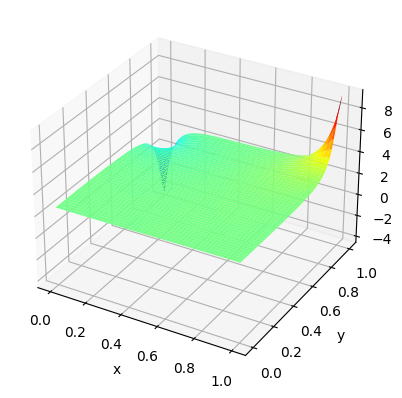

In [ ]:
# Pressure field
plot3D_Matrix(XX,YY,PP10)

Re = 100

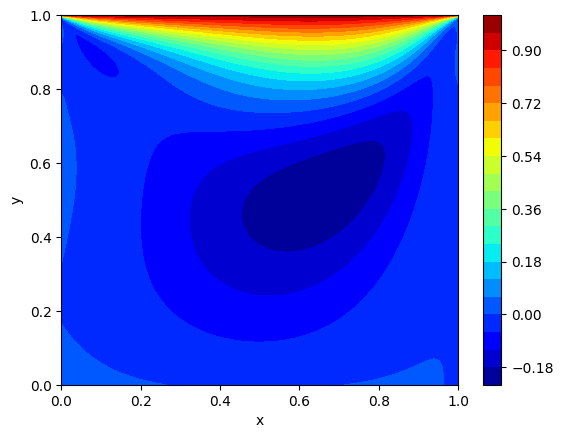

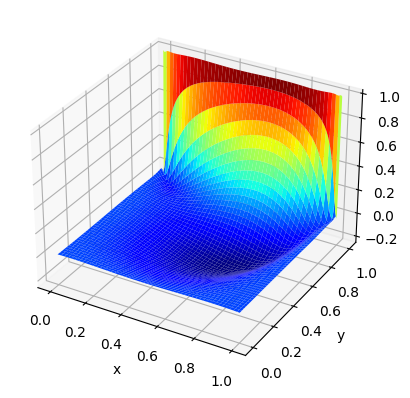

In [ ]:
# Horizontal flow velocity
plot3D_Matrix(XX,YY,UU100)

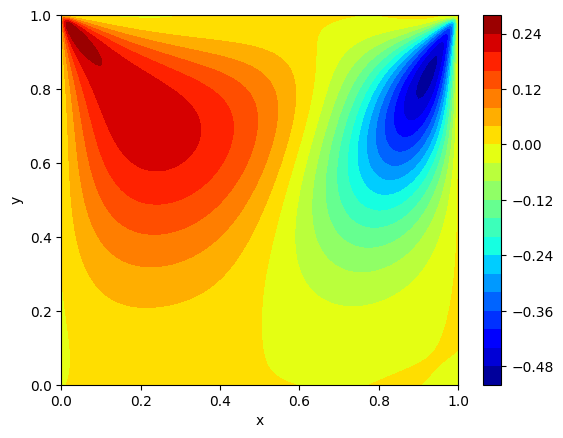

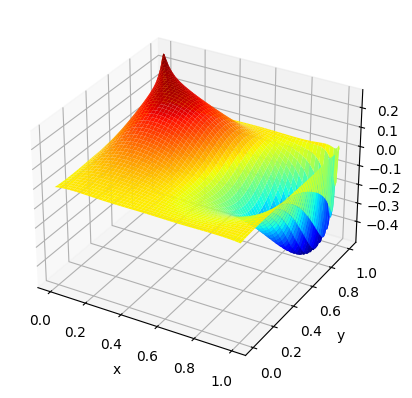

In [ ]:
# Vertical flow velocity
plot3D_Matrix(XX,YY,VV100)

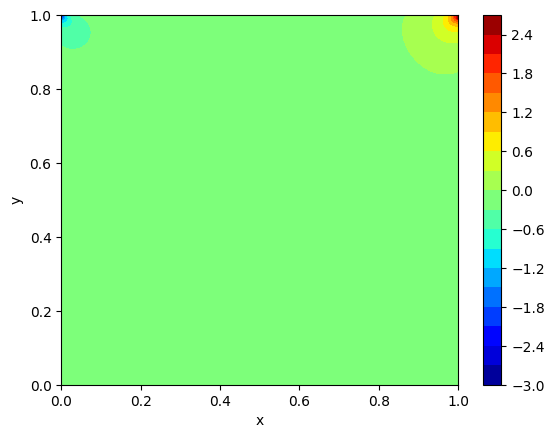

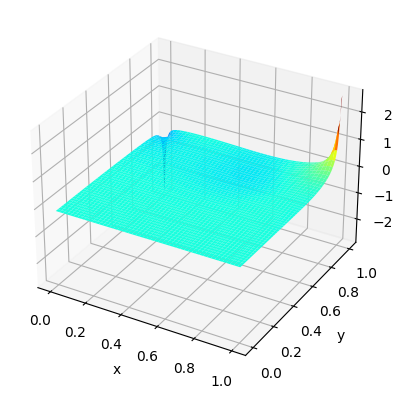

In [ ]:
# Pressure field
plot3D_Matrix(XX,YY,PP100)

#Horizontal and vertical velocities at centerline
In this section we examine the accuracy of the Re=100 model comparing the velocity fields predicted along the horizontal and vertical centerlines against well stablished results for this exact problem.

In [ ]:
centerline= 0.5*torch.ones(150,1)
xx = XX[0,:].reshape(-1,1)
yy = YY[:,0].reshape(-1,1)

In [ ]:
#Accurate values of the solution at centerline obtained through numerical simulation
xRe100 = np.array([1.0000, 0.9688, 0.9609, 0.9531, 0.9453, 0.9375, 0.9063, 0.8594, 0.5000, 0.1653, 0.0938, 0.0781, 0.0703, 0.0625, 0.0000])
Re_100vh = np.array([0.0000, -0.05906, -0.07391, -0.08864, -0.10313, -0.11758, -0.16914, -0.22445, 0.05454, 0.16077, 0.12317, 0.10890, 0.10091, 0.09233, 0.0000])

yRe100 = np.array([1.00000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000])
Re_100uv = np.array([1.00000, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641, -0.20581, -0.21090, -0.15662, -0.10150, -0.06434, -0.04775, -0.04192, -0.03717, 0.00000])


In [ ]:
# Evaluation of the models at centerline
u_clh_10, v_clh_10, p_clh_10, fhx, ghx, hhx = model10(xx, centerline)
u_clv_10, v_clv_10, p_clv_10, fvx, gvx, hvx = model10(centerline, yy)

u_clh_100, v_clh_100, p_clh_100, fh0x, gh0x, hh0x = model100(xx, centerline)
u_clv_100, v_clv_100, p_clv_100, fv0x, gv0x, hv0x = model100(centerline, yy)

#Conversion to numpy arrays for representation
v_clh_10n = v_clh_10.detach().numpy()
u_clv_10n = u_clv_10.detach().numpy()

v_clh_100n = v_clh_100.detach().numpy()
u_clv_100n = u_clv_100.detach().numpy()

Re = 100

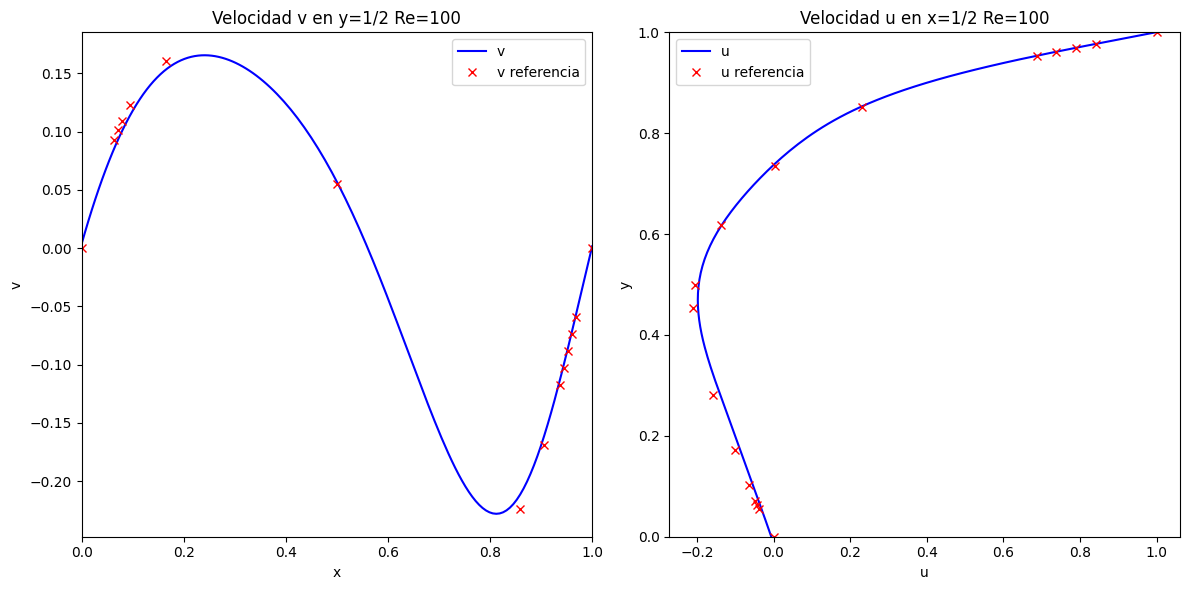

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(xx.detach().numpy(), v_clh_100n, 'b-', label='v')
plt.plot(xRe100, Re_100vh, 'rx', label='v referencia')  # Reference solution

plt.xlabel('x')
plt.ylabel('v')
plt.title('Velocidad v en y=1/2 Re=100')
plt.legend()
plt.xlim(0, 1)


plt.subplot(1, 2, 2)
plt.plot(u_clv_100n, yy.detach().numpy(), 'b-', label='u')
plt.plot(Re_100uv, yRe100, 'rx', label='u referencia')  # Reference solution

plt.xlabel('u')
plt.ylabel('y')
plt.title('Velocidad u en x=1/2 Re=100')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Re = 10

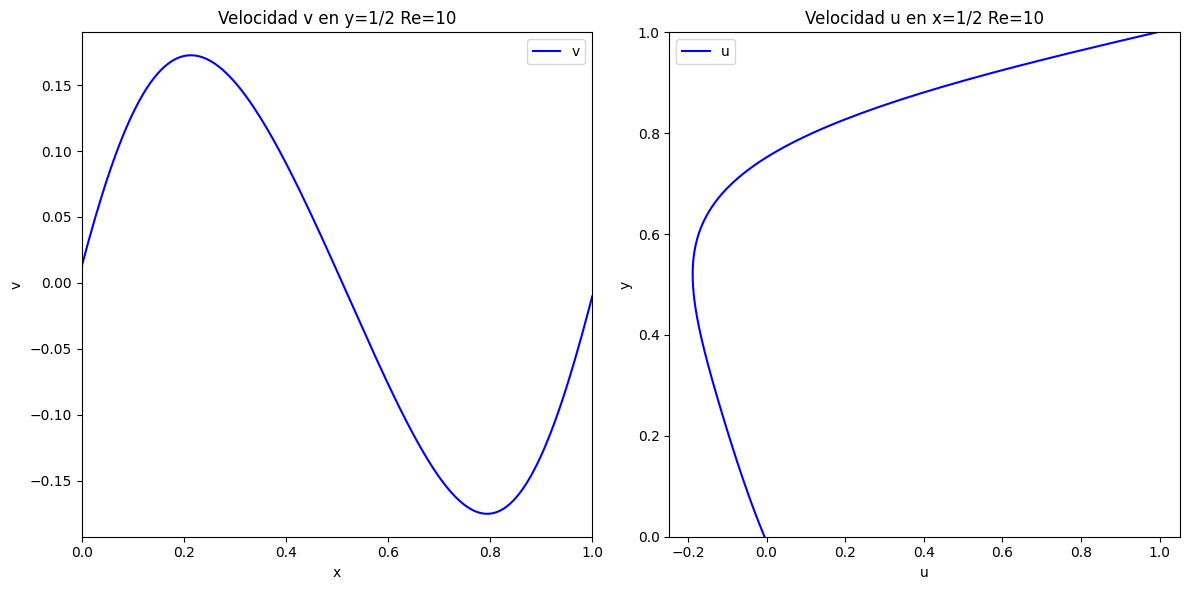

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(xx.detach().numpy(), v_clh_10n, 'b-', label='v')

plt.xlabel('x')
plt.ylabel('v')
plt.title('Velocidad v en y=1/2 Re=10')
plt.legend()
plt.xlim(0, 1)


plt.subplot(1, 2, 2)
plt.plot(u_clv_10n, yy.detach().numpy(), 'b-', label='u')

plt.xlabel('u')
plt.ylabel('y')
plt.title('Velocidad u en x=1/2 Re=10')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

#Streamline plots
These plots represent the trajectory a particle introduced in the cavity would follow according to the velocity and pressure fields.

Re = 10

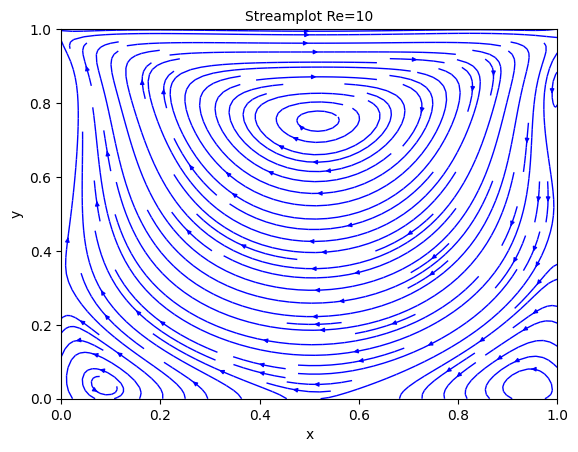

In [ ]:
xp=XX.numpy()
yp=YY.numpy()
up10=UU10.numpy().transpose(1,0)
vp10=VV10.numpy().transpose(1,0)

fig, ax = plt.subplots()
ax.streamplot(xp, yp, up10, vp10, density=1.5, color='blue', linewidth=1, arrowsize=0.6)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('Streamplot Re=10', fontsize=10)

plt.show()

Re = 100

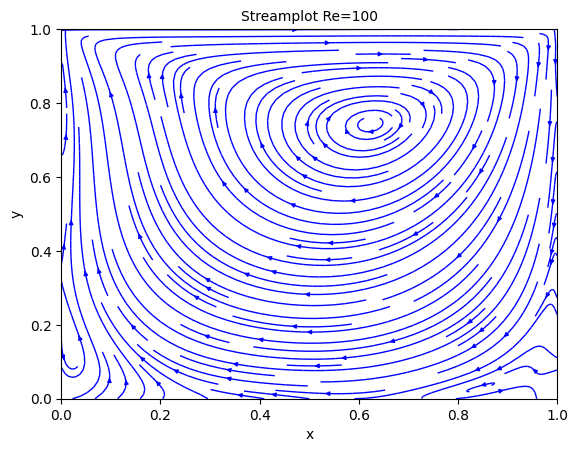

In [ ]:
up100=UU100.numpy().transpose(1,0)
vp100=VV100.numpy().transpose(1,0)

fig, ax = plt.subplots()
ax.streamplot(xp, yp, up100, vp100, density=1.5, color='blue', linewidth=1, arrowsize=0.6)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('Streamplot Re=100', fontsize=10)
plt.ylim(0, 1)  # Ajustar límite del eje x

plt.show()